In [1]:
import os
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
## uncomment for colab

# from google.colab import drive
# drive.mount('/content/drive')
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/BVP.zip"

In [2]:
gesture = {'Push & Pull':1,
            'Sweep':2,
            'Clap':3,
            'Slide':4,
            'Draw-N (V)':5,
            'Draw-O (V)':6,
            'Draw-Rectangle':7,
            'Draw-Triangle':8,
            'Draw-Zigzag (H)':9,
            'Draw-Zigzag (V)':10,
            'Draw-N (H)':11,
            'Draw-O (H)':12,
            'Draw-1':13,
            'Draw-2':14,
            'Draw-3':15,
            'Draw-4':16,
            'Draw-5':17,
            'Draw-6':18,
            'Draw-7':19,
            'Draw-8':20,
            'Draw-9':21,
            'Draw-0':22,
            }

dataset_gesture = { '20181109':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181112':['Draw-1', 'Draw-2', 'Draw-3', 'Draw-4', 'Draw-5', 'Draw-6', 'Draw-7', 'Draw-8', 'Draw-9', 'Draw-0'],
                    '20181115':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181117':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181118':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (V)', 'Draw-Zigzag (V)', 'Draw-N (V)'],
                    '20181121':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181127':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181128':['Push & Pull', 'Sweep', 'Clap', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)'],
                    '20181130':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181204':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181205':['Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181206':['Slide', 'Draw-O (H)', 'Draw-Zigzag (H)', 'Draw-N (H)', 'Draw-Triangle', 'Draw-Rectangle'],
                    '20181208':['Push & Pull', 'Sweep', 'Clap'],
                    '20181209':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)'],
                    '20181211':['Push & Pull', 'Sweep', 'Clap', 'Slide', 'Draw-O (H)', 'Draw-Zigzag (H)'],
                    }

# Parameters

In [3]:
fraction_for_test = 0.2
data_dir = 'BVP/'
ALL_MOTION = [i for i in range(1, 10)]
N_MOTION = len(ALL_MOTION) # Number of output classes
T_MAX = 38 # Number of timestamps
n_gru_hidden_units = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [ ]:
def onehot_encoding(label, num_class):
    # label(list)=>_label(ndarray): [N,]=>[N,num_class]
    label = np.array(label).astype('int32')
    # assert (np.arange(0,np.unique(label).size)==np.unique(label)).prod()    # Check label from 0 to N
    label = np.squeeze(label)
    _label = np.eye(num_class)[label-1]     # from label to onehot
    return _label

def normalize_data(data_1):
    # data(ndarray)=>data_norm(ndarray): [20,20,T]=>[20,20,T]
    data_1_max = np.concatenate((data_1.max(axis=0),data_1.max(axis=1)),axis=0).max(axis=0)
    data_1_min = np.concatenate((data_1.min(axis=0),data_1.min(axis=1)),axis=0).min(axis=0)
    if (len(np.where((data_1_max - data_1_min) == 0)[0]) > 0):
        return data_1
    data_1_max_rep = np.tile(data_1_max,(data_1.shape[0],data_1.shape[1],1))
    data_1_min_rep = np.tile(data_1_min,(data_1.shape[0],data_1.shape[1],1))
    data_1_norm = (data_1 - data_1_min_rep) / (data_1_max_rep - data_1_min_rep)
    return  data_1_norm

def zero_padding(data, T_MAX):
    # data(list)=>data_pad(ndarray): [20,20,T1/T2/...]=>[20,20,T_MAX]
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        data_pad.append(np.pad(data[i], ((0, 0),(0,0),(T_MAX - t,0)), 'constant', constant_values = 0).tolist())
    return np.array(data_pad)

def load_data(path_to_data, motion_sel, target_user):
    global T_MAX
    data = []
    label = []
    for data_root, data_dirs, data_files in os.walk(path_to_data):
        for data_file_name in data_files:
            file_path = os.path.join(data_root, data_file_name)
            date = data_root.split('/')[1].split('-')[0]
            try:
                data_1 = scio.loadmat(file_path)['velocity_spectrum_ro']
                ges_num = int(data_file_name.split('-')[1])
                ges_lable = dataset_gesture[date][ges_num-1]
                label_1 = gesture[ges_lable]
                user = int(data_file_name.split('-')[0].split('user')[-1])
                location = int(data_file_name.split('-')[2])
                orientation = int(data_file_name.split('-')[3])
                repetition = int(data_file_name.split('-')[4])
                # print(data_1.shape)
                
                # Update T_MAX
                if T_MAX < np.array(data_1).shape[2]:
                    T_MAX = np.array(data_1).shape[2]
                    
                # Select Motion
                if (label_1 not in motion_sel):
                    continue
                
                # Select User
                if user != target_user:
                    continue
                
                # Select Location
                # if (location not in [1,2,3,5]):
                #     continue

                # Select Orientation
                # if (orientation not in [1,2,4,5]):
                #     continue
                
                # Normalization
                data_normed_1 = normalize_data(data_1)
                
                                
            except Exception as error:
                # print(type(error).__name__,' : ', error)
                continue

            # Save List
            data.append(data_normed_1.tolist())
            label.append(label_1 - 1)

    # Zero-padding
    data = zero_padding(data, T_MAX)

    # Swap axes
    data = np.swapaxes(np.swapaxes(data, 1, 3), 2, 3)   # [N,20,20',T_MAX]=>[N,T_MAX,20,20']
    data = np.expand_dims(data, axis=2)    # [N,T_MAX,20,20]=>[N,T_MAX,20,20,1]

    # Convert label to ndarray
    label = np.array(label)

    # data(ndarray): [N,T_MAX,20,20,1], label(ndarray): [N,N_MOTION]
    return data, label

## Seperate and Save each clients data

In [ ]:
# Load data
try:
    os.mkdir('./dataset')
except:
    pass

for user in range(1, 17+1):
    print(f'client {user} data extraction:')
    data, label = load_data(data_dir, ALL_MOTION, target_user=user)
    torch.save({'data': data, 'label': label}, f'./dataset/user{user}.pt')
    print('\nLoaded dataset of ' + str(label.shape[0]) + ' samples, each sized ' + str(data[0,:,:].shape) + '\n')

### Plot data distribution

In [5]:
def survey(data, client_names, class_names):
    labels = client_names
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab10')(np.linspace(0.1, 0.9, len(class_names)))

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.invert_yaxis()
    
    # Set x-axis limit to the maximum number of samples across all clients
    ax.set_xlim(0, data.sum(axis=1).max() + 10)
    ax.set_xlabel('Number of samples')

    for i, (colname, color) in enumerate(zip(class_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)

    ax.legend(loc='best')
    ax.grid(True)
    
    return fig, ax

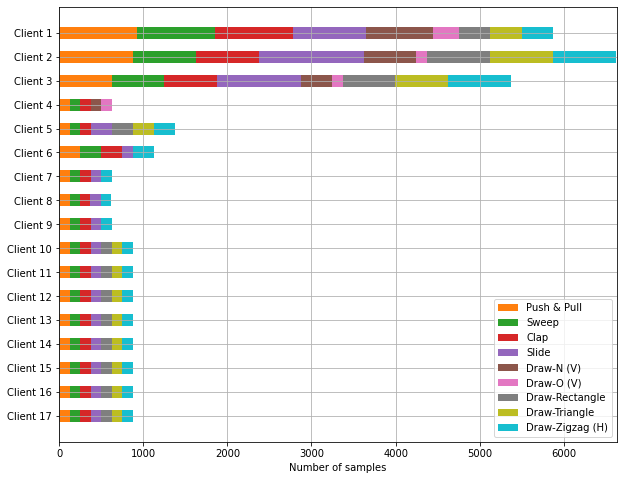

In [6]:
# Load datasets
num_clients = 17
num_classes = 9
client_names = [f'Client {i+1}' for i in range(num_clients)]
gesture_ = {v-1: k for k,v in gesture.items()}
class_names = [gesture_[i] for i in range(num_classes)]

data_matrix = np.zeros((num_clients, num_classes), dtype=int)
for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./dataset/user{i}.pt')['label']
    unique_classes, class_counts = np.unique(client_data, return_counts=True)
    data_matrix[i-1, unique_classes] = class_counts

survey(data_matrix, client_names, class_names)
plt.show()


### Reduce number of client

In [7]:
from shutil import copyfile

num_clients = 17

# Define paths for the new 
destination_folder = './data'
try:
    os.makedirs(destination_folder)
except:
    pass

merged_dataset_4 = {'data': [], 'label': []}
merged_dataset_5 = {'data': [], 'label': []}

for i in range(1, num_clients + 1):
    client_data = torch.load(f'./dataset/user{i}.pt')
    if 1 <= i <= 3:
        copyfile(f'./dataset/user{i}.pt', os.path.join(destination_folder, f'data{i}.pt'))
    elif 4 <= i <= 9:
        merged_dataset_4['data'].append(client_data['data'])
        merged_dataset_4['label'].append(client_data['label'])
    else:
        merged_dataset_5['data'].append(client_data['data'])
        merged_dataset_5['label'].append(client_data['label'])

merged_dataset_4 = {'data': np.concatenate(merged_dataset_4['data']), 'label': np.concatenate(merged_dataset_4['label'])}
merged_dataset_5 = {'data': np.concatenate(merged_dataset_5['data']), 'label': np.concatenate(merged_dataset_5['label'])}

# Save data and label separately
torch.save(merged_dataset_4, os.path.join(destination_folder, f'data4.pt'))
torch.save(merged_dataset_5, os.path.join(destination_folder, f'data5.pt'))

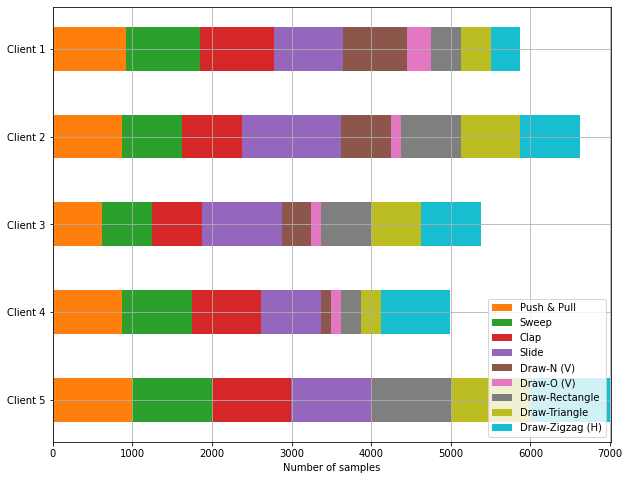

In [8]:
# Load datasets
num_clients = 5
num_classes = 9
client_names = [f'Client {i+1}' for i in range(num_clients)]
gesture_ = {v-1: k for k,v in gesture.items()}
class_names = [gesture_[i] for i in range(num_classes)]

data_matrix = np.zeros((num_clients, num_classes), dtype=int)
for i in range(1, num_clients + 1):
    # Load client data
    client_data = torch.load(f'./data/data{i}.pt')['label']
    unique_classes, class_counts = np.unique(client_data, return_counts=True)
    data_matrix[i-1, unique_classes] = class_counts

survey(data_matrix, client_names, class_names)
plt.show()

# Model

In [7]:
class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=2, padding='same'),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 10 * 10, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.cnn(x)

class ConvGRUModel(nn.Module):
    def __init__(self, hidden_size, num_classes, num_timestamps):
        super(ConvGRUModel, self).__init__()
        
        # CNN module for each input timestamp
        self.cnn_modules = nn.ModuleList([
            CNNModule() for _ in range(num_timestamps)
        ])
        
        # GRU layers
        self.gru = nn.GRU(32, hidden_size, num_layers=num_timestamps, batch_first=True, dropout=0.25)

        # Fully connected layer at the output of last GRU
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Relu activation for fully connected
        self.relu = nn.ReLU()
        # Softmax activation for classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply CNN module sequentially for each timestamp
        x = np.swapaxes(x, 0, 1)
        x = [module(xi) for module, xi in zip(self.cnn_modules, x)]
        x = torch.stack(x, dim=1)  # Stack along the time dimension
        
        # GRU layer
        x, _ = self.gru(x)

        # Apply ReLU activation after the GRU layer
        x = self.relu(x)

        # Fully connected layer at the output of last GRU
        x = self.fc_out(x[:, -1, :])
        
        # Softmax for classification
        x = self.softmax(x)

        return x

### check model

In [11]:
model = ConvGRUModel(n_gru_hidden_units, N_MOTION, T_MAX)
# print(model)

# Example input with batch size 16, 38 timestamps, height 20, width 20, and 1 channel
input_data = torch.randn(128, 38, 1, 20, 20)

# Forward pass
output = model(input_data)
print(output.shape)  # This should print torch.Size([16, 10]) assuming 10 output classes

c:\Users\Amirhosein\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
c:\Users\Amirhosein\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([128, 9])
